Analyze slowing beam profile data for X-B and v10s slowers.
Data were taken by translating a photodiode in x-direction on a translation stage, and using a Thorlabs line camera.

First, here, analyze the data taken by translating the photodiode on translation stage.

In [1]:
import numpy as np
import pandas as pd

# Load spreadsheet
xl = pd.ExcelFile('Slowing Beam Profiles.xlsx')

# Load a sheet into a DataFrame by its name
df = xl.parse('Sheet1')

# Convert the DataFrame to a numeric type
df = df.apply(pd.to_numeric, errors='coerce')

# Convert the DataFrame to a numpy array
numpy_array = df.values

# Split the numpy array into two arrays, one for each column
first_column = numpy_array[:, 0]
second_column = numpy_array[:, 1]

# Split the arrays at NaN values
first_column_split = np.split(first_column, np.where(np.isnan(first_column))[0])
second_column_split = np.split(second_column, np.where(np.isnan(second_column))[0])

# Remove the arrays with NaN values
first_column_split = [a[~np.isnan(a)] for a in first_column_split if a.size > 0]
second_column_split = [a[~np.isnan(a)] for a in second_column_split if a.size > 0]

#do it twice because somehow the first time it just converts nan to empty
all_x_data = [a[~np.isnan(a)] for a in first_column_split if a.size > 0]
all_PD_data = [a[~np.isnan(a)] for a in second_column_split if a.size > 0]

# Convert all_x_data from inches to millimeters, accounting for multiplicative factor due to non-normal incidence
incidence_factor = 52.5/54.5
all_x_data_mm = [x * 25.4 * incidence_factor if i < 4 else x * 25.4 for i, x in enumerate(all_x_data)]

In [2]:
from scipy.optimize import curve_fit

# Define the Gaussian function
def gaussian(x, mean, amplitude, standard_deviation):
    return amplitude * np.exp( - ((x - mean) / standard_deviation) ** 2)

# Store the fit parameters for each set
fit_params = []

for x, y in zip(all_x_data_mm, all_PD_data):
    # Initial guess for the parameters
    initial_guess = [np.mean(x), np.max(y), np.std(x)]
    
    # Perform the curve fit
    params, params_covariance = curve_fit(gaussian, x, y, p0=initial_guess)
    
    fit_params.append(params)

# fit_params now contains the fitted parameters for each set

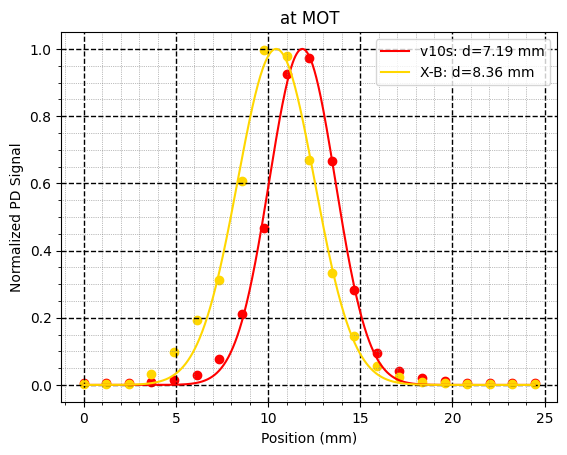

Difference in peak locations: 1.42 mm


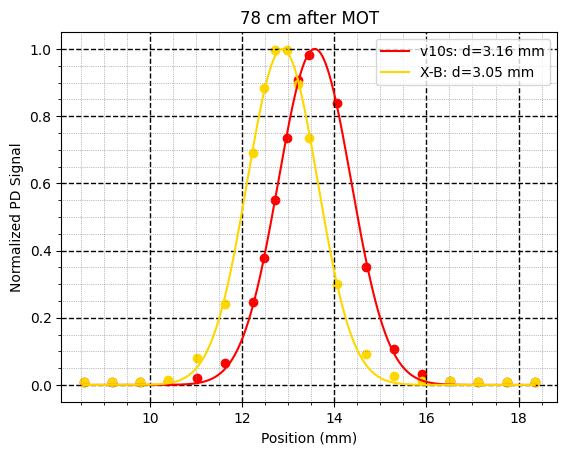

Difference in peak locations: 0.7 mm


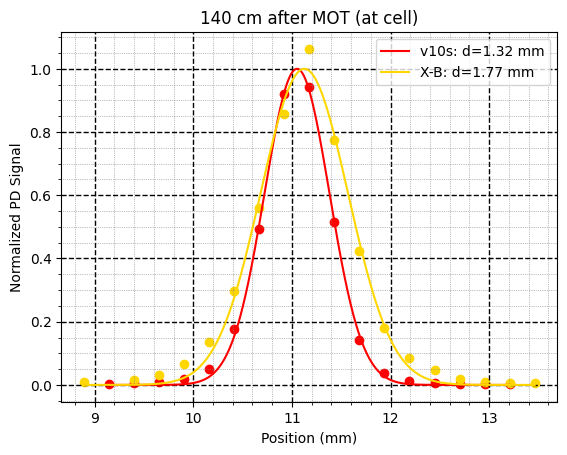

Difference in peak locations: 0.07 mm


In [3]:
import matplotlib.pyplot as plt

titles = ['at MOT', '78 cm after MOT', '140 cm after MOT (at cell)', '77 cm before MOT']
labels = ['v10s', 'X-B']
colors = ['red', 'gold']
peak_x_values = []

for i, (x, y, params) in enumerate(zip(all_x_data_mm, all_PD_data, fit_params)):
    # Only use the data points with x > 0.35 for the fourth set
    
    if i == 4:
        mask = x > 0.35*25.4  # Create a mask where each value is True if the corresponding value in x is greater than 0.35*25.4
        x = x[mask]  # Apply the mask to x
        y = y[mask]  # Apply the same mask to y

    # Generate a range of x values for the fitted function
    x_fit = np.linspace(min(x), max(x), 1000)
    
    # Compute the fitted y values
    y_fit = gaussian(x_fit, *params)

    #calculate new y-values based on normalized PD signal (to peak value)
    y = y / np.max(y_fit)
    y_fit = y_fit / np.max(y_fit)
        
    # Plot the original data
    plt.scatter(x, y, color=colors[i%2])
    
    # Plot the fitted function
    plt.plot(x_fit, y_fit, label=labels[i%2]+f': d={round(2 * np.sqrt(2) * np.abs(params[2]), 2)} mm', color=colors[i%2])
    
    # Store the peak x-value (mean of the Gaussian)
    peak_x_values.append(params[0])

    if i % 2 == 1:
        plt.xlabel('Position (mm)')
        plt.ylabel('Normalized PD Signal')
        plt.legend()  # Add a legend
        plt.title(titles[i//2])
        plt.grid(linestyle = '--', which = 'major', linewidth = 1, color='black')
        plt.grid(linestyle = ':', which = 'minor', linewidth = 0.5, color = 'gray')
        plt.minorticks_on()
        plt.show()
        difference = np.abs(peak_x_values[i] - peak_x_values[i-1])
        print(f'Difference in peak locations: {round(difference, 2)} mm')

Next, analyze the data taken on the Thorlabs line camera.

In [4]:
import pandas as pd

# List of CSV file names
file_names = ['v10s_MOT_pos.csv', 'XB_MOT_pos.csv', 'v10s_55in_pos.csv', 'XB_55in_pos.csv', 'v10s_cell_pos.csv', 'XB_cell_pos.csv', 'v10s_after_lens.csv', 'XB_after_lens.csv']

# Lists to store the numpy arrays
pixel_nums = []
norm_signal = []

for file_name in file_names:
    # Load data from CSV file into a DataFrame
    df = pd.read_csv(file_name, header=None)

    # Convert the DataFrame to a numpy array
    numpy_array = df.values

    # Split the numpy array into two arrays, one for each column
    first_column = numpy_array[:, 0]*7e-3 # Convert pixel numbers to mm
    second_column = numpy_array[:, 1]

    # Append the arrays to the lists
    pixel_nums.append(first_column)
    norm_signal.append(second_column)

In [5]:
from scipy.optimize import curve_fit
import numpy as np

# Define the Gaussian function
def gaussian(x, mean, amplitude, standard_deviation, offset):
    return amplitude * np.exp( - ((x - mean) / standard_deviation) ** 2) + offset

# Store the fit parameters for each set
fit_params2 = []

for x, y in zip(pixel_nums, norm_signal):
    # Initial guess for the parameters
    initial_guess = [np.mean(x), np.max(y), np.std(x), 0]
    
    # Perform the curve fit
    params, params_covariance = curve_fit(gaussian, x, y, p0=initial_guess)
    
    fit_params2.append(params)

# fit_params now contains the fitted parameters for each set

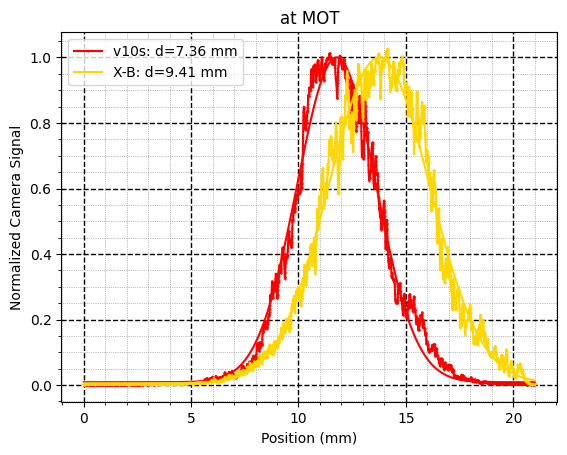

Difference in peak locations: 1.98 mm


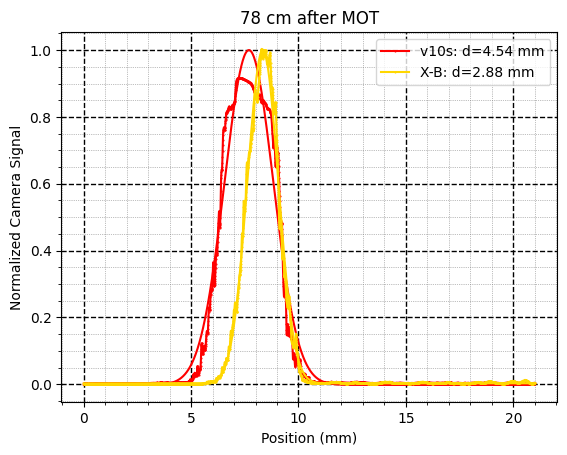

Difference in peak locations: 0.65 mm


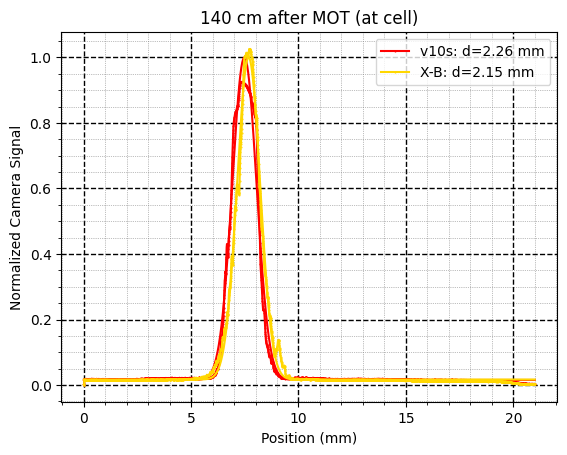

Difference in peak locations: 0.2 mm


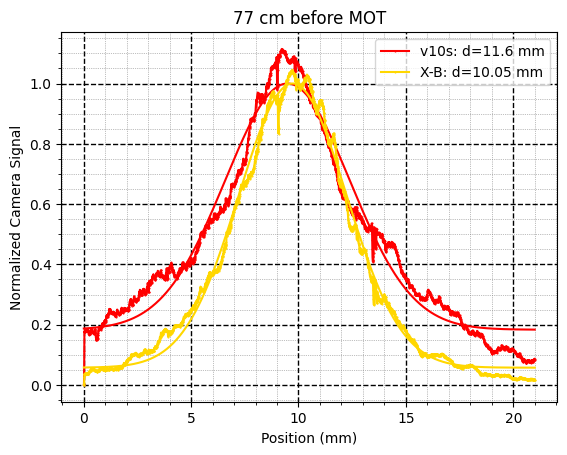

Difference in peak locations: 0.24 mm


In [6]:
import matplotlib.pyplot as plt

labels2 = ['v10s', 'X-B']
colors2 = ['red', 'gold']
peak_x_values2 = []

# Iterate through pairs of numpy arrays
for i, (first_column, second_column, params) in enumerate(zip(pixel_nums, norm_signal, fit_params2)):
    # Generate a range of x values for the fitted function
    x_fit = np.linspace(min(first_column), max(first_column), 1000)
    
    # Compute the fitted y values
    y_fit = gaussian(x_fit, *params)

    #calculate new y-values based on normalized PD signal (to peak value)
    second_column = second_column / np.max(y_fit)
    y_fit = y_fit / np.max(y_fit)
    
    # Plot the data
    plt.plot(first_column, second_column, label=labels2[i%2]+f': d={round(2 * np.sqrt(2) * np.abs(params[2]), 2)} mm', color=colors2[i%2], marker='o', ms=0.5)
    
    # Plot the fitted function
    plt.plot(x_fit, y_fit, color=colors2[i%2])

    # Add a legend
    plt.legend()

    # Store the peak x-value (mean of the Gaussian)
    peak_x_values2.append(params[0])

    if i % 2 == 1:
        plt.title(titles[i//2])
        plt.xlabel('Position (mm)')
        plt.ylabel('Normalized Camera Signal')
        plt.grid(linestyle = '--', which = 'major', linewidth = 1, color='black')
        plt.grid(linestyle = ':', which = 'minor', linewidth = 0.5, color = 'gray')
        plt.minorticks_on()
        plt.show()
        difference2 = np.abs(peak_x_values2[i] - peak_x_values2[i-1])
        print(f'Difference in peak locations: {round(difference2, 2)} mm')

plot the result for the MOT beam on the line camera

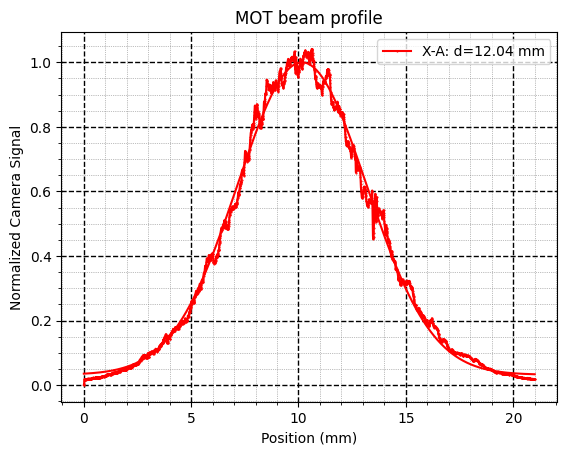

In [7]:
file_name = 'XA_MOT_beam.csv'

# Load data from CSV file into a DataFrame
df = pd.read_csv(file_name, header=None)

# Convert the DataFrame to a numpy array
numpy_array = df.values

# Split the numpy array into two arrays, one for each column
first_column = numpy_array[:, 0]*7e-3 # Convert pixel numbers to mm
second_column = numpy_array[:, 1]

# Perform the curve fit
params, params_covariance = curve_fit(gaussian, first_column, second_column, p0=[np.mean(first_column), np.max(second_column), np.std(first_column), 0])

# Generate a range of x values for the fitted function
x_fit = np.linspace(min(first_column), max(first_column), 1000)

# Compute the fitted y values
y_fit = gaussian(x_fit, *params)

#calculate new y-values based on normalized PD signal (to peak value)
second_column = second_column / np.max(y_fit)
y_fit = y_fit / np.max(y_fit)
    

#plot the data and the fit
plt.plot(first_column, second_column, label='X-A'+f': d={round(2 * np.sqrt(2) * np.abs(params[2]), 2)} mm', color='red', marker='o', ms=0.5)
plt.plot(x_fit, y_fit, color='red')
plt.legend()
plt.title('MOT beam profile')
plt.xlabel('Position (mm)')
plt.ylabel('Normalized Camera Signal')
plt.grid(linestyle = '--', which = 'major', linewidth = 1, color='black')
plt.grid(linestyle = ':', which = 'minor', linewidth = 0.5, color = 'gray')
plt.minorticks_on()
plt.show()


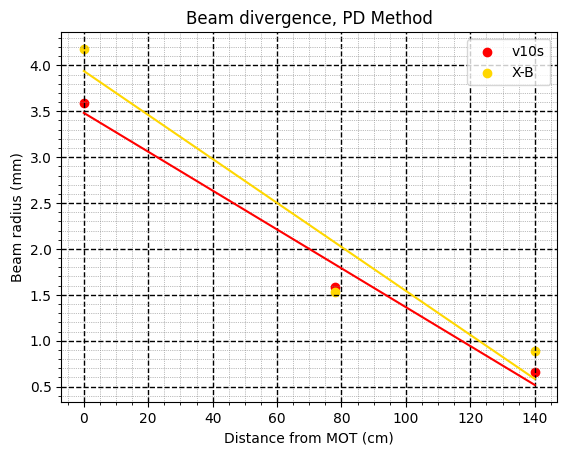

Half-angle divergence of v10s: 2.12 mrad
Half-angle divergence of X-B: 2.4 mrad


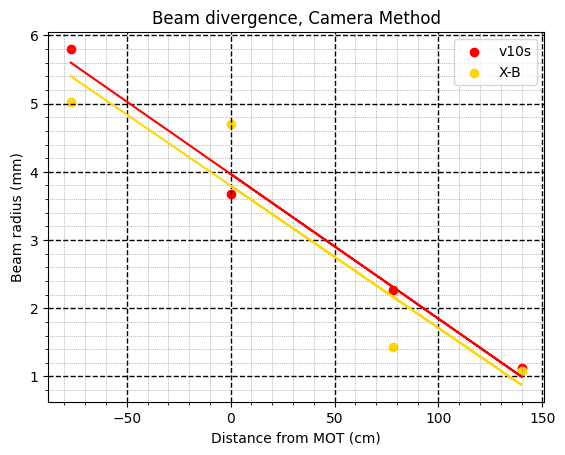

Half-angle divergence of v10s: 2.12 mrad
Half-angle divergence of X-B: 2.09 mrad


In [8]:
#plot the beam divergence of v10s and X-B for both sets of measurements

zvals = [0, 78, 140]
zvals2 = [0, 78, 140, -77]
beam_radius = [np.sqrt(2) * np.abs(params[2]) for params in fit_params] #from PD method
beam_radius_XA = beam_radius[::2]
beam_radius_XB = beam_radius[1::2]
beam_radius2 = [np.sqrt(2) * np.abs(params[2]) for params in fit_params2] #from camera method
beam_radius_XA2 = beam_radius2[::2]
beam_radius_XB2 = beam_radius2[1::2]

#fit best fit lines to beam_radius data
def linear(x, m, b):
    return m*x + b

from scipy.optimize import curve_fit

popt, pcov = curve_fit(linear, zvals, beam_radius_XA)
popt2, pcov2 = curve_fit(linear, zvals, beam_radius_XB)
popt3, pcov3 = curve_fit(linear, zvals2, beam_radius_XA2)
popt4, pcov4 = curve_fit(linear, zvals2, beam_radius_XB2)

#plot the data and the fit
plt.scatter(zvals, beam_radius_XA, label='v10s', color='red')
plt.scatter(zvals, beam_radius_XB, label='X-B', color='gold')
plt.plot(zvals, linear(np.array(zvals), *popt), color='red')
plt.plot(zvals, linear(np.array(zvals), *popt2), color='gold')
plt.legend()
plt.title('Beam divergence, PD Method')
plt.xlabel('Distance from MOT (cm)')
plt.ylabel('Beam radius (mm)')
plt.grid(linestyle = '--', which = 'major', linewidth = 1, color='black')
plt.grid(linestyle = ':', which = 'minor', linewidth = 0.5, color = 'gray')
plt.minorticks_on()
plt.show()

#compute half-angle divergence in millradians
half_angle_XA = np.abs(np.arctan(popt[0]*1e-1) * 1e3)
half_angle_XB = np.abs(np.arctan(popt2[0]*1e-1) * 1e3)

#print result in mrad
print(f'Half-angle divergence of v10s: {round(half_angle_XA, 2)} mrad')
print(f'Half-angle divergence of X-B: {round(half_angle_XB, 2)} mrad')

plt.scatter(zvals2, beam_radius_XA2, label='v10s', color='red')
plt.scatter(zvals2, beam_radius_XB2, label='X-B', color='gold')
plt.plot(zvals2, linear(np.array(zvals2), *popt3), color='red')
plt.plot(zvals2, linear(np.array(zvals2), *popt4), color='gold')
plt.legend()
plt.title('Beam divergence, Camera Method')
plt.xlabel('Distance from MOT (cm)')
plt.ylabel('Beam radius (mm)')
plt.grid(linestyle = '--', which = 'major', linewidth = 1, color='black')
plt.grid(linestyle = ':', which = 'minor', linewidth = 0.5, color = 'gray')
plt.minorticks_on()
plt.show()

#compute half-angle divergence
half_angle_XA2 = np.abs(np.arctan(popt3[0]*1e-1) * 1e3)
half_angle_XB2 = np.abs(np.arctan(popt4[0]*1e-1) * 1e3)

#print result in mrad
print(f'Half-angle divergence of v10s: {round(half_angle_XA2, 2)} mrad')
print(f'Half-angle divergence of X-B: {round(half_angle_XB2, 2)} mrad')

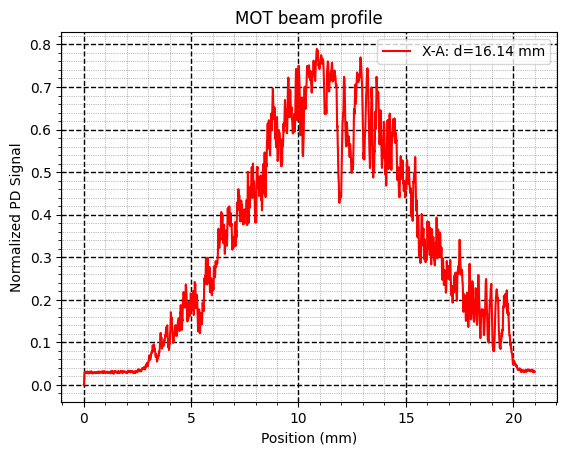

In [9]:
file_name = 'v10s_MOT_new.csv'

# Load data from CSV file into a DataFrame
df = pd.read_csv(file_name, header=None)

# Convert the DataFrame to a numpy array
numpy_array = df.values

# Split the numpy array into two arrays, one for each column
first_column = numpy_array[:, 0]*7e-3 # Convert pixel numbers to mm
second_column = numpy_array[:, 1]

# Perform the curve fit
params, params_covariance = curve_fit(gaussian, first_column, second_column, p0=[np.mean(first_column), np.max(second_column), np.std(first_column), 0])

#plot the data and the fit
plt.plot(first_column, second_column, label='X-A'+f': d={round(2 * np.sqrt(2) * np.abs(params[2]), 2)} mm', color='red')
plt.legend()
plt.title('MOT beam profile')
plt.xlabel('Position (mm)')
plt.ylabel('Normalized PD Signal')
plt.grid(linestyle = '--', which = 'major', linewidth = 1, color='black')
plt.grid(linestyle = ':', which = 'minor', linewidth = 0.5, color = 'gray')
plt.minorticks_on()
plt.show()